### 📊 **Informe: Modelo de Clasificación de Género de Películas**

### 👥 Integrantes
- Miguel Mateo Sandoval Torres  
- Diego Dayan Niño Pérez  
- Camilo Andrés Flórez Esquivel  
- Andrea Amariles Escobar  

### 📚 Curso
**Machine Learning y Procesamiento de Lenguaje Natural**

### 🗓️ Fecha
**Mayo de 2025**

### **Introducción** <br>
<p style="text-align: justify;">
Este informe presenta el desarrollo de un modelo de aprendizaje automático, cuyo objetivo es predecir la probabilidad de que una película pertenezca a un género en particular. A lo largo del documento se describen las etapas fundamentales del proceso, incluyendo el preprocesamiento de datos, la selección y calibración del modelo, el entrenamiento y evaluación del rendimiento del mismo, al igual que métricas comparativas con versiones alternativas, con el objetivo de evidenciar el proceso de selección del modelo final. Finalmente, se presenta el procedimiento de disponibilización del modelo predictivo mediante una API.<p>

In [ ]:
# Importación librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch                                                                   # Librería principal de PyTorch
from torch import cuda                                                         # Librería para trabajar con GPU
USE_GPU = torch.cuda.is_available()                                            # Activar uso de GPU
device = torch.device('cuda' if USE_GPU else 'cpu')                            # Dispositivo (GPU o CPU)
print("GPU de uso: ", torch.cuda.get_device_name())
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import ast
from itertools import chain
from collections import Counter

### **Carga y Preprocesamiento de Datos**<br>
<p style="text-align: justify;">
El objetivo del preprocesamiento de datos es preparar los datos para su uso en los modelos de prediccion implementados durante el desarollo del proyecto. Debido a la naturaleza de las diferentes opciones de modelos a utilizar se plantean los siguientes metodos:

- Usar NLTK y WordNetLemmatizer
- Usar SpaCy
- Usar BERT

los primeros dos metodos se basan en la aplicacion de mejores practicas para preparar textos como pueden ser Normalización de texto, Tokenización avanzada, Lematización, Eliminación de stopwords y Filtrado de tokens. Minetras que el modelo BERT, es un modelo de lenguaje preentrenado. Este cuenta con grandes ventajas frente a los primeros:

- Contexto: Captura el contexto de la oracion. NLTK y SpaCy procesan individualmente las palabras.
- Embeddings densos y contextuales.
- No requiere Lematización.
- Rendimiento en clasificación alto.

Por estas razones se espera que tenga un resultado favorable frente a los dos primeros modelos.


#### Carga de los datos

In [ ]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

# Visualización datos de entrenamiento
dataTraining.head()

# Visualización datos de test
dataTesting.head()

Revision de los datos. Validación de valores nulos y valores duplicados.

In [ ]:
# Revisión general de los datos
nulos = dataTraining.isnull().sum()               # Busqueda de valores nulos
duplicados = dataTraining.duplicated().sum()      # Busqueda de valores repetidos
titulos_unicos = dataTraining['title'].nunique()  # Títulos únicos de películas
dataTraining.info()                               # Información general de los datos

print(f'Valores nulos:\n{nulos}')
print(f'\nValores duplicados: {duplicados}')
print(f'\nCantidad de títulos únicos: {titulos_unicos}')

In [ ]:
# Conversión de la columna 'genres' de string a lista
dataTraining['genres_list'] = dataTraining['genres'].apply(ast.literal_eval)

In [ ]:
# Visualización de películas por género
frecuencia_generos = list(chain.from_iterable(dataTraining['genres_list']))
conteo_generos = Counter(frecuencia_generos)

sorted_genres = conteo_generos.most_common()
genres, counts = zip(*sorted_genres)

plt.figure(figsize=(12, 6))
bars = plt.bar(genres, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.title('Frecuencia de géneros en el dataset')
plt.tight_layout()

# Paso 5: Añadir etiquetas a cada barra
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=9)

plt.show()

Se entrenaron y calibraron diferentes modelos predictivos. Se definieron RandonForet, LogisticRegression y Redes neuraonales para comparar su rendimiento. 


$$
\begin{array}{l|c|c|c}
\textbf{} & \textbf{NLTK y WordNetLemmatizer} & \textbf{SpaCy} & \textbf{BERT} \\
\hline
\textbf{RF} & 0.7914 & 0.7909 & 0.8612 \\
\textbf{Rlogistica} & 0.8075 & 0.8087 & 0.9115 \\
\textbf{Redes} & 0.8075 & 0.9115 & 0.9370 \\
\end{array}
$$

#### Modelos seleccionado para el prepocesamiento: BERT

In [ ]:
# Función de procesamiento de texto con BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

def get_bert_embedding(text):
    """
    Genera un embedding numérico para un texto utilizando BERT.
    - Tokeniza el texto de entrada usando el tokenizer de BERT preentrenado.
    - Procesa el texto con el modelo BERT para obtener los embeddings de cada token.
    - Calcula el promedio de los embeddings de todos los tokens para obtener una única representación del texto.
    - Devuelve el embedding como un vector de NumPy.

    Parámetros:
        text (str): Texto de entrada a convertir en embedding.

    Retorna:
        np.ndarray: Vector numérico que representa el significado del texto según BERT.
    """
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state.mean(dim=1)
        return embedding.squeeze().numpy()

### **Entrenamiento de Modelos Predictivos**

#### Modelo seleccionado: Red Neuronal

Se selecciona un modelo de redes neuraonales por su mayor rendimiento en conjunto con el modelo BERT. Esta convinacion es ampliamente utilizada para este tipo de problemas de procesamiento de lenguaje para obtener mejores resultados al utilizar metodos que sean compatibles entre si.

In [ ]:
mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(dataTraining['genres'])

In [ ]:
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Generate embeddings for training data
dataTraining['plot_clean_bert'] = dataTraining['plot'].progress_apply(get_bert_embeddings)

# Generate embeddings for test data (important!)
dataTesting['plot_clean_bert'] = dataTesting['plot'].progress_apply(get_bert_embeddings)

# 4. Now proceed with your model
X = np.vstack(dataTraining['plot_clean_bert'].values)
y = y_genres

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Calibracion del modelo

Se implemento la funcion nn_model_params, la cual nos permitio construir y entrenar la red neuronal para la clasificion de generos. Esta funcion permite ajustar aspectos como el optimizador, numero de neuronas, funcion de activacion, tama;o del batch y numero de epocas. Ademas, cuenta con tecnicas de regularizacion como dropout y early stopping para prevenir el sobreasjutste. 

In [ ]:
# Red neuronal con BERT embeddings para clasificación multilabel (mejorada con optimizador AdamW y ajustes de hiperparámetros)

output_var = y_train.shape[1]
dims = X_train.shape[1]
print(output_var, 'output variables')
print(dims, 'input variables')

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible y configurada")
else:
    print("No se encontró GPU, usando CPU")

# Modelo con AdamW y mejoras

def nn_model_params(optimizer='adamw',
                   neurons=384,
                   batch_size=64,
                   epochs=150,
                   activation='relu',
                   patience=7,
                   loss='binary_crossentropy'):
    K.clear_session()
    model = Sequential()
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(output_var, activation='sigmoid'))

    model.compile(optimizer=AdamW(learning_rate=0.0005),
                  loss=loss,
                  metrics=['accuracy', metrics.AUC(name='auc')])

    early_stopping = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, PlotLossesKeras()],
                        verbose=1)

    return model, history

# Parámetros mejorados
params = {
    'optimizer': 'adamw',
    'neurons': 384,
    'batch_size': 64,
    'epochs': 150,
    'activation': 'relu',
    'patience': 10,
    'loss': 'binary_crossentropy'
}

model, history = nn_model_params(**params)

print("\nEvaluación en conjunto de validación:")
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

y_pred_test = model.predict(np.vstack(dataTesting['plot_clean_bert'].values))

model.save('modelo_nn.keras')
print("Modelo guardado como modelo_nn.keras")

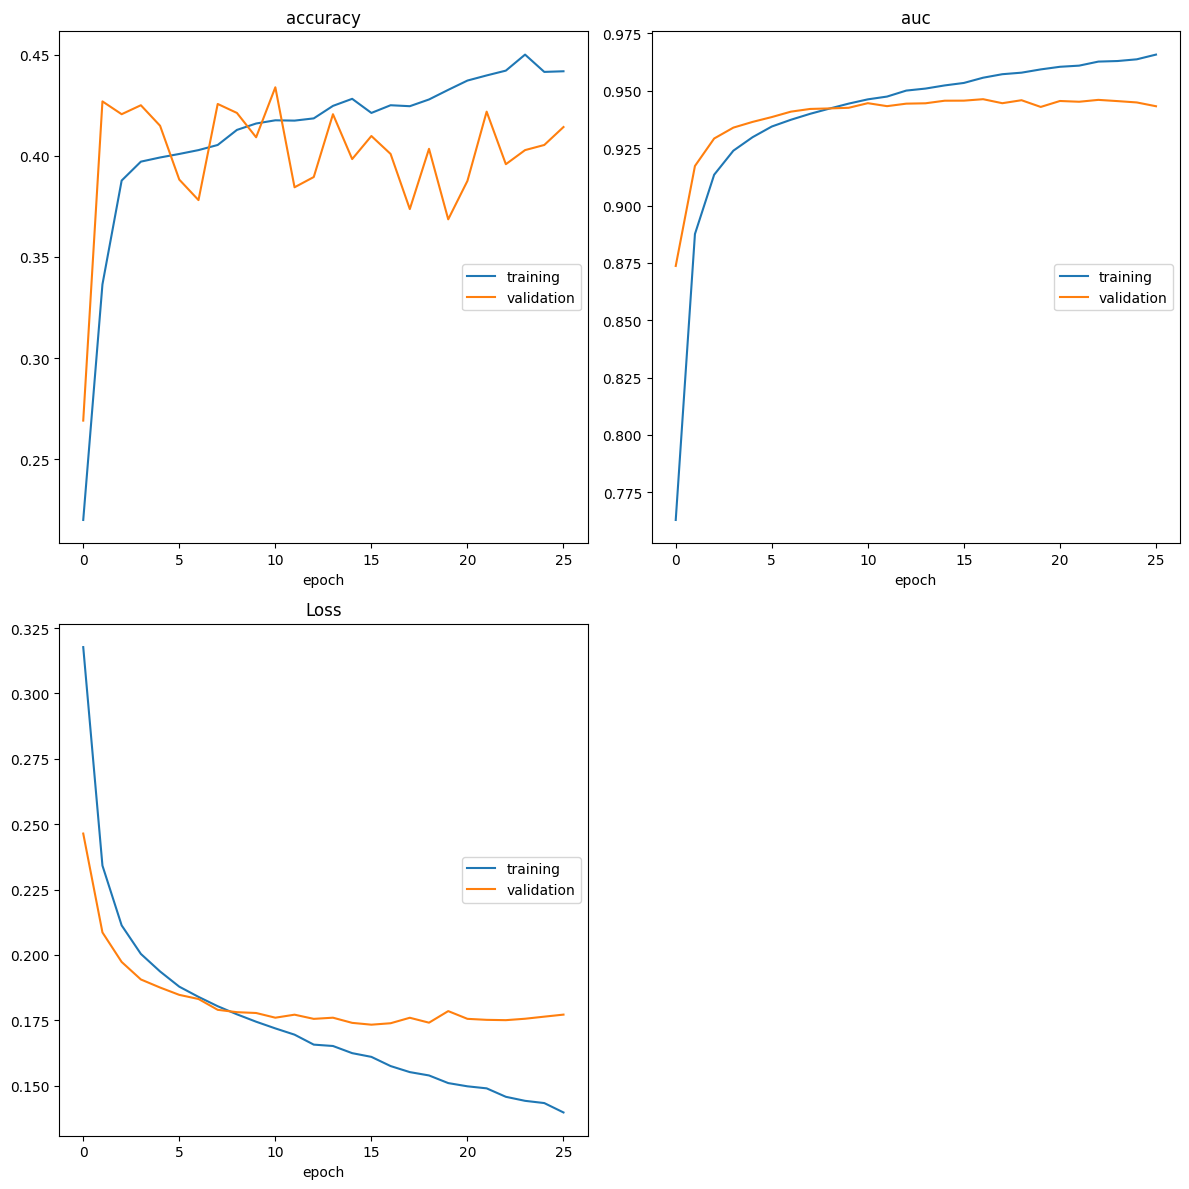

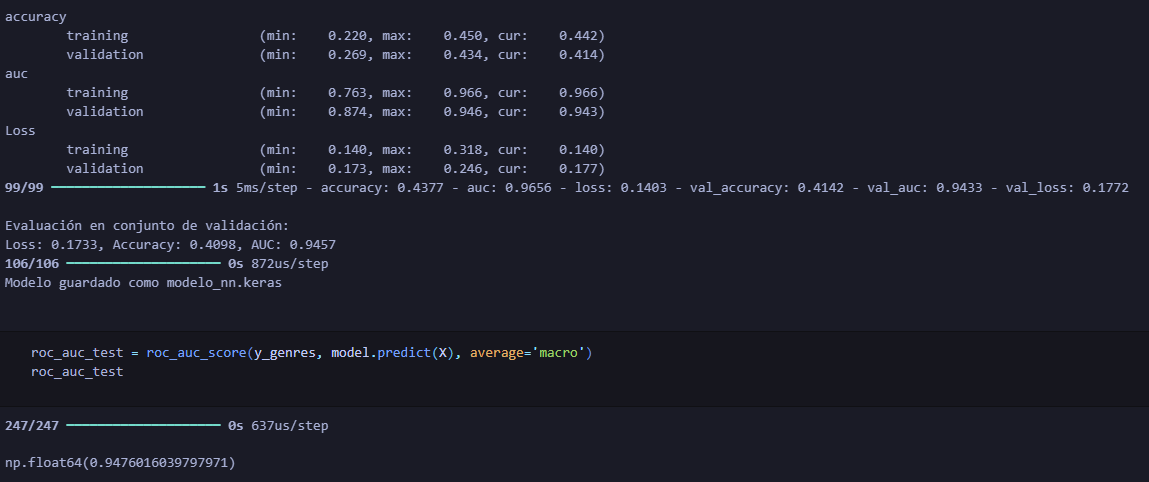

### **Disponibilización del Modelo**

El proceso para asegurar la disponibilidad del modelo se estructuró en tres pasos:

**Construcción y almacenamiento del modelo:**<br>
Se construyó un modelo y se almacenó en un archivo .pkl.
Debido a las limitaciones de tamaño en GitHub, no se utilizó el modelo de la competencia. En su lugar, se implementó un modelo de NLTK y WordNetLemmatizer junto con el modelo de prediccion:
"OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))". Adicional, el archivo .pkl contiene tanto el modelo como el vectorizacio: "joblib.dump((clf, vect), 'genres_movie.pkl', compress=3)".

**Creación de la función en un archivo .py:**<br>
El archivo .pkl generado fue utilizado para crear una función dentro de un archivo .py.
Esta función fue diseñada para ser importada posteriormente, facilitando la modularidad y reutilización del código.

**Desarrollo de la API:**<br>
Finalmente, se construyó la API en otro archivo .py.
Esta API importa la función previamente creada y configura un método GET, el cual recibe el parametro 'Plot' para la predicción del modelo de forma sencilla y estructurada. La respuesta se muestra en forma de lista filtrado para una visibilidad más comoda por un threshold de 0.1.

##### Servidor Utilizado
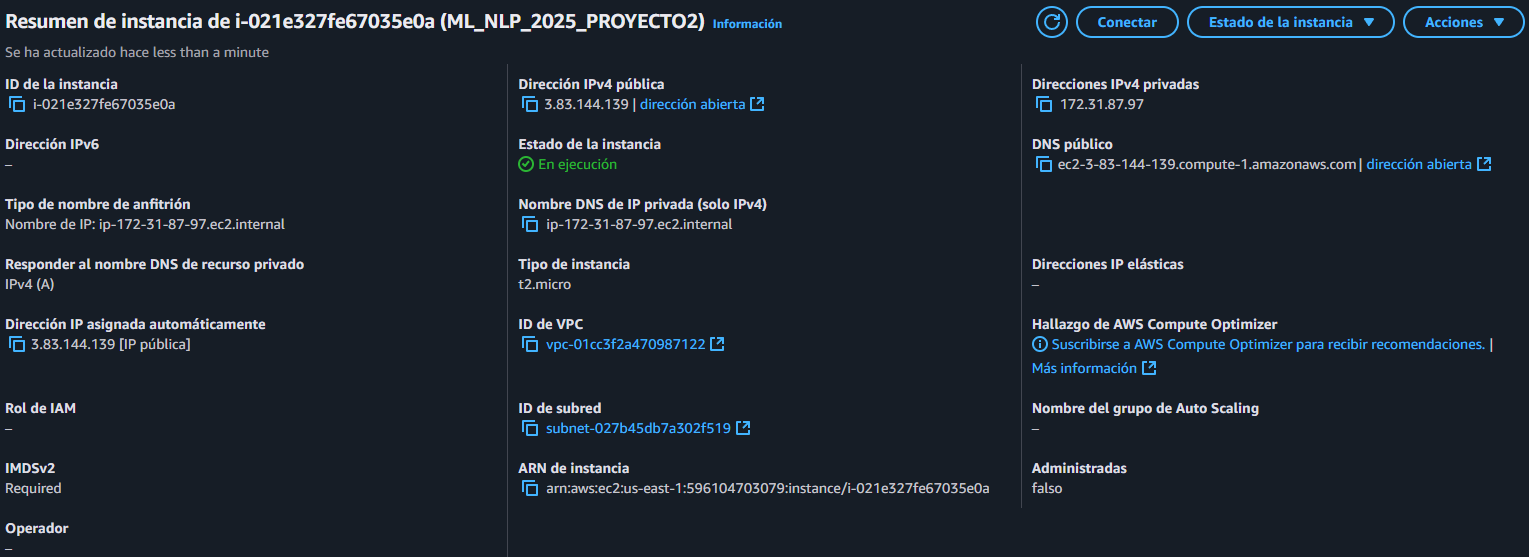

API: http://3.83.144.139:5000

#### Resultados de la API

In [ ]:
dataTesting.head(2)

#### Entrada 0:

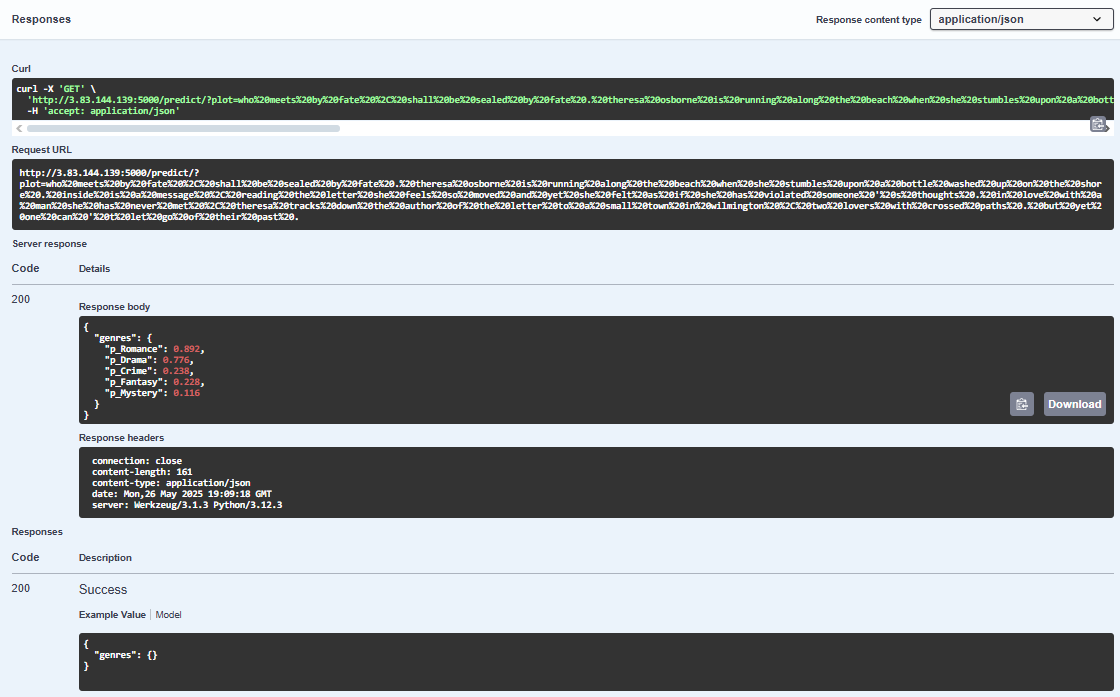

#### Entrada 1:

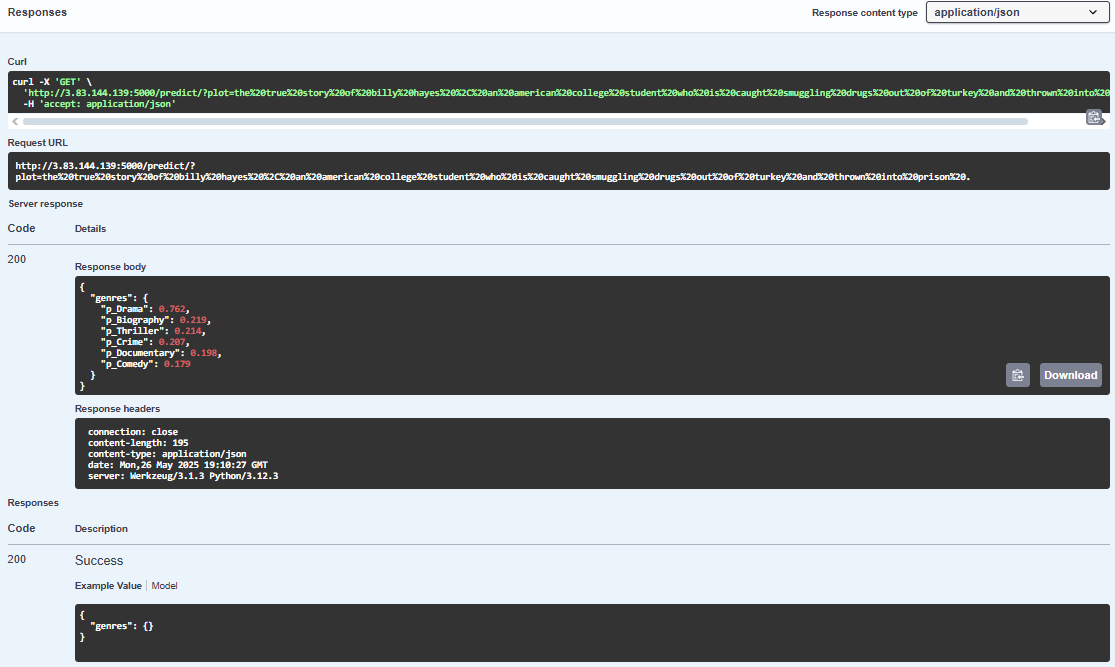

## Conclusiones

En este proyecto, se desarrolló un modelo PLN para predecir la probabilidad de que una película pertenezca a un género en particular. A lo largo del notebook, se implementaron diversas etapas clave. A continuación, se resumen los puntos más destacados:

1. Preprocesamiento de Datos:
   - Se realizó una validacion de los datos confirmando la ausencia de datos faltantes o duplicados.
   - Se validaron 3 modelos de preprocesamiento para contrastar los resultados optenidos por cada metodo. El mejor metodo fue el modelo BERT, esto fue un resultado esperado.
2. Selección de Características:
   - Se utilizó una funcion para encontrar los parametros optimos para el modelo de redes neuronales.
3. Entrenamiento del Modelo:
   - Se implementó un modelo de procesamiento de texto BERT en conjunto con un modelo de redes neuronales.
   - El uso de metricas como el AUC, LOSS y accuracy, permitió evaluar el desempeño del modelo de manera robusta.
4. Evaluación del Modelo:
   - La métrica seleccionada, AUC, demostró ser adecuada para medir el error en las predicciones de genero.
   - El modelo final mostró un buen desempeño en el conjunto de validación, reflejando su capacidad para capturar patrones en los datos.
5. Disponibilización del Modelo:
   - Se almacenó el modelo entrenado en un archivo .pkl y se desarrolló una API para facilitar su uso en aplicaciones externas.
   - La API permite realizar predicciones de manera sencilla, asegurando la accesibilidad del modelo para usuarios finales.